In [23]:
# Standard library
import os
import re
import sys
import warnings
from pathlib import Path

# Third-party - Data and scientific computing
import contextily as cx
import geopandas as gpd
import numpy as np
import pandas as pd
from tqdm import tqdm

# Shapely-specific imports for spatial analysis
import shapely
from shapely import STRtree
from shapely.geometry import LineString, MultiLineString, Point
from shapely.ops import nearest_points, snap

# Matplotlib-specific imports for figures
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, ListedColormap, Normalize
from matplotlib.lines import Line2D
from matplotlib.patches import Patch, Rectangle
from matplotlib.ticker import FuncFormatter, MultipleLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Suppress warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=RuntimeWarning)

In [24]:
BASE_DIR = Path.cwd().parent   # if notebook is in /notebooks
data_path = BASE_DIR / "input_files"
figure_path = BASE_DIR / "figures"

osm_path = data_path / "SRB.osm.pbf"
roads_path = data_path / 'DeoniceRSDP-Jul2025..shp'

In [25]:
features = gpd.read_file(osm_path, layer="lines")
features = features[features["highway"] != None]
osm_keys = ['highway','name','maxspeed','oneway','lanes','surface']

In [26]:
def _extract_value(text, key):
    """
    Parse the value of a specific key from a semi-structured OSM tag string.

    Args:
        text (str): Raw OSM `other_tags` string.
        key (str): Key to extract value for.

    Returns:
        str or None: Extracted value or None.
    """
    pattern = rf'"{key}"=>"([^"]+)"'
    try:
        match = re.search(pattern, text)
        if match:
            return match.group(1)
        return None
    except:
        return None

In [27]:
road_types = ['primary','trunk','motorway','motorway_link','trunk_link','primary_link','secondary','secondary_link','tertiary','tertiary_link','residential','road','unclassified','track']

for key in osm_keys:
    if key not in features.columns:
        features[key] = features["other_tags"].apply(
            lambda x: _extract_value(x, key)
        )

base_network = features[features['highway'].isin(road_types)].reset_index(drop=True)
base_network = base_network[['osm_id','highway','name','maxspeed','oneway','lanes','surface','geometry']] #,'bridge','tunnel'    


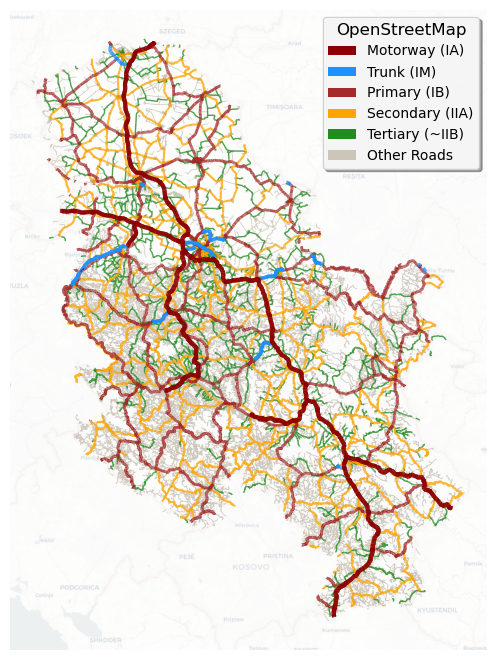

In [28]:
# Define the road types to include
road_types = ['primary','trunk','motorway','motorway_link','trunk_link','primary_link','secondary','secondary_link','tertiary','tertiary_link','residential','road','unclassified']

# Filter for the road types we want to plot
base_network_filtered = base_network[base_network['highway'].isin(road_types)].copy()

# Create a mapping to group _link roads with their parent categories
def map_road_category(highway_type):
    if highway_type in ['motorway', 'motorway_link']:
        return 'motorway'
    elif highway_type in ['trunk', 'trunk_link']:
        return 'trunk'
    elif highway_type in ['primary', 'primary_link']:
        return 'primary'
    elif highway_type in ['secondary', 'secondary_link']:
        return 'secondary'
    elif highway_type in ['tertiary', 'tertiary_link']:
        return 'tertiary'
    elif highway_type in ['residential', 'road', 'unclassified', 'track']:
        return 'other'
    else:
        return highway_type
        
# Apply the mapping
base_network_filtered['road_category'] = base_network_filtered['highway'].apply(map_road_category)

# Define colors matching the Serbian road network hierarchy
# Motorway ≈ IA (highest tier), Trunk ≈ IM, Primary ≈ IB, Secondary ≈ IIA, Tertiary ≈ IIB
road_colors = {
    'motorway': '#8B0000',    # Dark red/maroon (like Serbian IA - highways)
    'trunk': '#1E90FF',       # Blue (like Serbian IM - main roads)
    'primary': '#A52A2A',     # Dark red/brown (like Serbian IB - regional roads)
    'secondary': '#FFA500',   # Orange (like Serbian IIA - secondary roads)
    'tertiary': '#228B22' ,    # Green (like Serbian IIB - local roads)
    'other': '#ccc5b9'        # Grey (residential, road, unclassified, track)

}

# Define line widths - hierarchical from motorway (thickest) to tertiary (thinnest)
road_widths = {
    'motorway': 3.0,   # Highways - thickest
    'trunk': 2.5,      # Trunk roads
    'primary': 2.0,    # Primary roads
    'secondary': 1.5,  # Secondary roads
    'tertiary': 1,    # Tertiary roads - thinnest
    'other': 0.6       # Other roads - thinnest
}

# Define the order for plotting and legend (highest to lowest hierarchy)
road_hierarchy = ['motorway', 'trunk', 'primary', 'secondary', 'tertiary', 'other']

# Create figure with high DPI for crisp visuals
fig, ax = plt.subplots(1, 1, figsize=(20, 8), facecolor='white')

# Convert to Web Mercator for plotting with basemap
network_mercator = base_network_filtered.to_crs(3857)

# Plot each road category with its specific color and width
# Plot in reverse hierarchy order so motorways appear on top
for category in reversed(road_hierarchy):
    if category in base_network_filtered['road_category'].values:
        category_roads = network_mercator[network_mercator['road_category'] == category]
        category_roads.plot(
            ax=ax,
            color=road_colors[category],
            linewidth=road_widths[category],
            alpha=0.8,
            zorder=road_widths[category]  # Higher tier roads on top
        )

# Add basemap with optimal styling for PNG
cx.add_basemap(
    ax=ax, 
    source=cx.providers.CartoDB.Positron, 
    alpha=0.4,
    attribution=False
)

# Enhance the plot styling
ax.set_aspect('equal')
ax.axis('off')  # Remove axis for cleaner look

# Create custom legend in upper right corner
legend_elements = []
road_labels = {
    'motorway': 'Motorway (IA)',
    'trunk': 'Trunk (IM)', 
    'primary': 'Primary (IB)',
    'secondary': 'Secondary (IIA)',
    'tertiary': 'Tertiary (~IIB)',
    'other' : "Other Roads"
}

for category in road_hierarchy:
    if category in base_network_filtered['road_category'].values:
        legend_elements.append(
            Patch(facecolor=road_colors[category], 
                  label=road_labels[category], 
                  edgecolor='none')
        )

legend = ax.legend(handles=legend_elements, 
                  title='OpenStreetMap', 
                  loc='upper right',
                  fontsize=10,
                  title_fontsize=12,
                  frameon=True,
                  fancybox=True,
                  shadow=True,
                  framealpha=0.9,
                  facecolor='white',
                  edgecolor='#cccccc')

# Enhance overall plot appearance
plt.tight_layout()
plt.subplots_adjust(top=0.88, bottom=0.08, left=0.02, right=0.94)
plt.savefig(figure_path / 'osm_road_network.png', dpi=300, bbox_inches='tight')
plt.show()

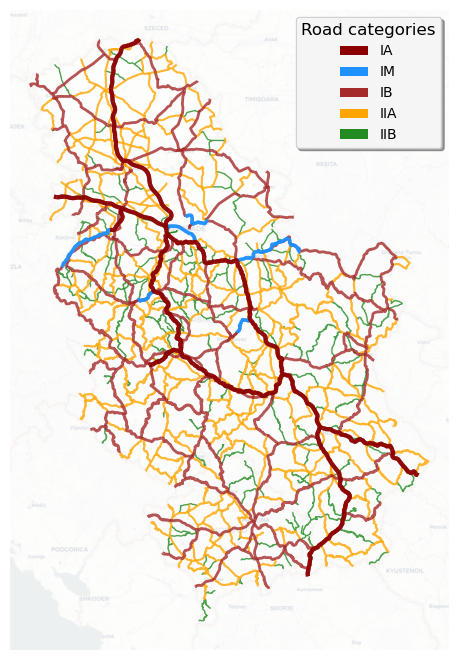

In [29]:
gdf = gpd.read_file(roads_path)

# Filter for the road categories we want to plot
road_categories = ['IA', 'IM', 'IB', 'IIA', 'IIB']
gdf_filtered = gdf[gdf['kategorija'].isin(road_categories)].copy()

# Define colors based on the screenshot legend
road_colors = {
    'IA': '#8B0000',   # Dark red/maroon
    'IM': '#1E90FF',   # Blue
    'IB': '#A52A2A',   # Dark red/brown (slightly different from IA)
    'IIA': '#FFA500',  # Orange
    'IIB': '#228B22'   # Green
}

# Define line widths - higher tier roads are wider
road_widths = {
    'IA': 3.0,   # Highways - thickest
    'IM': 2.5,   # Main roads
    'IB': 2.0,   # Regional roads
    'IIA': 1.5,  # Secondary roads
    'IIB': 1.0   # Local roads - thinnest
}

# Create figure with high DPI for crisp visuals
fig, ax = plt.subplots(1, 1, figsize=(20, 8), facecolor='white')

# Convert to Web Mercator for plotting with basemap
gdf_mercator = gdf_filtered.to_crs(3857)

# Plot each road category with its specific color and width
for category in road_categories:
    if category in gdf_filtered['kategorija'].values:
        category_roads = gdf_mercator[gdf_mercator['kategorija'] == category]
        category_roads.plot(
            ax=ax,
            color=road_colors[category],
            linewidth=road_widths[category],
            alpha=0.8,
            zorder=road_widths[category]  # Higher tier roads on top
        )

# Add basemap with optimal styling for PNG
cx.add_basemap(
    ax=ax, 
    source=cx.providers.CartoDB.Positron, 
    alpha=0.4,
    attribution=False
)

# Enhance the plot styling
ax.set_aspect('equal')
ax.axis('off')  # Remove axis for cleaner look

# Create custom legend in upper right corner matching your template style
legend_elements = []
for category in road_categories:
    if category in gdf_filtered['kategorija'].values:
        legend_elements.append(
            Patch(facecolor=road_colors[category], 
                  label=f'{category}', 
                  edgecolor='none')
        )

legend = ax.legend(handles=legend_elements, 
                  title='Road categories', 
                  loc='upper right',
                  fontsize=10,
                  title_fontsize=12,
                  frameon=True,
                  fancybox=True,
                  shadow=True,
                  framealpha=0.9,
                  facecolor='white',
                  edgecolor='#cccccc')

# Enhance overall plot appearance
plt.tight_layout()
plt.subplots_adjust(top=0.88, bottom=0.08, left=0.02, right=0.94)
plt.savefig(figure_path / 'road_categories.png', dpi=300, bbox_inches='tight')
plt.show()

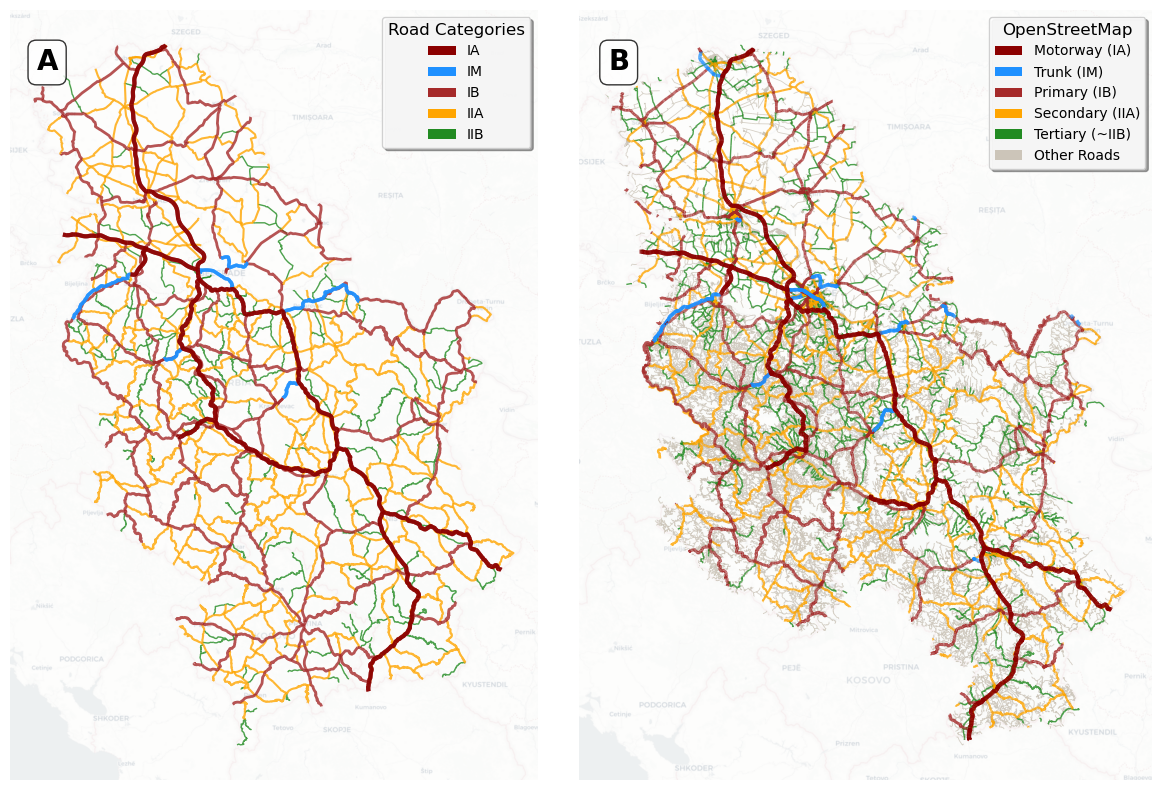

In [30]:
# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8), facecolor='white')

# ============ LEFT MAP (A) - Serbian Road Network ============
road_categories = ['IA', 'IM', 'IB', 'IIA', 'IIB']
gdf_filtered = gdf[gdf['kategorija'].isin(road_categories)].copy()

road_colors_serbian = {
    'IA': '#8B0000', 'IM': '#1E90FF', 'IB': '#A52A2A', 
    'IIA': '#FFA500', 'IIB': '#228B22'
}
road_widths_serbian = {
    'IA': 3.0, 'IM': 2.5, 'IB': 2.0, 'IIA': 1.5, 'IIB': 1.0
}

gdf_mercator = gdf_filtered.to_crs(3857)

for category in road_categories:
    if category in gdf_filtered['kategorija'].values:
        category_roads = gdf_mercator[gdf_mercator['kategorija'] == category]
        category_roads.plot(
            ax=ax1, color=road_colors_serbian[category],
            linewidth=road_widths_serbian[category], alpha=0.8,
            zorder=road_widths_serbian[category]
        )

cx.add_basemap(ax=ax1, source=cx.providers.CartoDB.Positron, alpha=0.4, attribution=False)
ax1.set_aspect('equal')
ax1.axis('off')

legend_elements1 = [Patch(facecolor=road_colors_serbian[cat], label=cat, edgecolor='none')
                    for cat in road_categories if cat in gdf_filtered['kategorija'].values]
ax1.legend(handles=legend_elements1, title='Road Categories', loc='upper right',
           fontsize=10, title_fontsize=12, frameon=True, fancybox=True, shadow=True,
           framealpha=0.9, facecolor='white', edgecolor='#cccccc')

ax1.text(0.05, 0.95, 'A', transform=ax1.transAxes, fontsize=20, fontweight='bold',
         verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))

# ============ RIGHT MAP (B) - OSM Road Network ============
road_types = ['primary', 'trunk', 'motorway', 'motorway_link', 'trunk_link', 'primary_link',
              'secondary', 'secondary_link', 'tertiary', 'tertiary_link', 'residential', 
              'road', 'unclassified']
base_network_filtered = base_network[base_network['highway'].isin(road_types)].copy()

def map_road_category(highway_type):
    if highway_type in ['motorway', 'motorway_link']:
        return 'motorway'
    elif highway_type in ['trunk', 'trunk_link']:
        return 'trunk'
    elif highway_type in ['primary', 'primary_link']:
        return 'primary'
    elif highway_type in ['secondary', 'secondary_link']:
        return 'secondary'
    elif highway_type in ['tertiary', 'tertiary_link']:
        return 'tertiary'
    elif highway_type in ['residential', 'road', 'unclassified', 'track']:
        return 'other'
    else:
        return highway_type

base_network_filtered['road_category'] = base_network_filtered['highway'].apply(map_road_category)

road_colors_osm = {
    'motorway': '#8B0000', 'trunk': '#1E90FF', 'primary': '#A52A2A',
    'secondary': '#FFA500', 'tertiary': '#228B22', 'other': '#ccc5b9'
}
road_widths_osm = {
    'motorway': 3.0, 'trunk': 2.5, 'primary': 2.0,
    'secondary': 1.5, 'tertiary': 1.0, 'other': 0.6
}
road_hierarchy = ['motorway', 'trunk', 'primary', 'secondary', 'tertiary', 'other']
road_labels = {
    'motorway': 'Motorway (IA)', 'trunk': 'Trunk (IM)', 'primary': 'Primary (IB)',
    'secondary': 'Secondary (IIA)', 'tertiary': 'Tertiary (~IIB)', 'other': 'Other Roads'
}

network_mercator = base_network_filtered.to_crs(3857)

for category in reversed(road_hierarchy):
    if category in base_network_filtered['road_category'].values:
        category_roads = network_mercator[network_mercator['road_category'] == category]
        category_roads.plot(
            ax=ax2, color=road_colors_osm[category],
            linewidth=road_widths_osm[category], alpha=0.8,
            zorder=road_widths_osm[category]
        )

cx.add_basemap(ax=ax2, source=cx.providers.CartoDB.Positron, alpha=0.4, attribution=False)
ax2.set_aspect('equal')
ax2.axis('off')

legend_elements2 = [Patch(facecolor=road_colors_osm[cat], label=road_labels[cat], edgecolor='none')
                    for cat in road_hierarchy if cat in base_network_filtered['road_category'].values]
ax2.legend(handles=legend_elements2, title='OpenStreetMap', loc='upper right',
           fontsize=10, title_fontsize=12, frameon=True, fancybox=True, shadow=True,
           framealpha=0.9, facecolor='white', edgecolor='#cccccc')

ax2.text(0.05, 0.95, 'B', transform=ax2.transAxes, fontsize=20, fontweight='bold',
         verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))

# Final adjustments
plt.tight_layout()
plt.savefig(figure_path / 'road_network_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

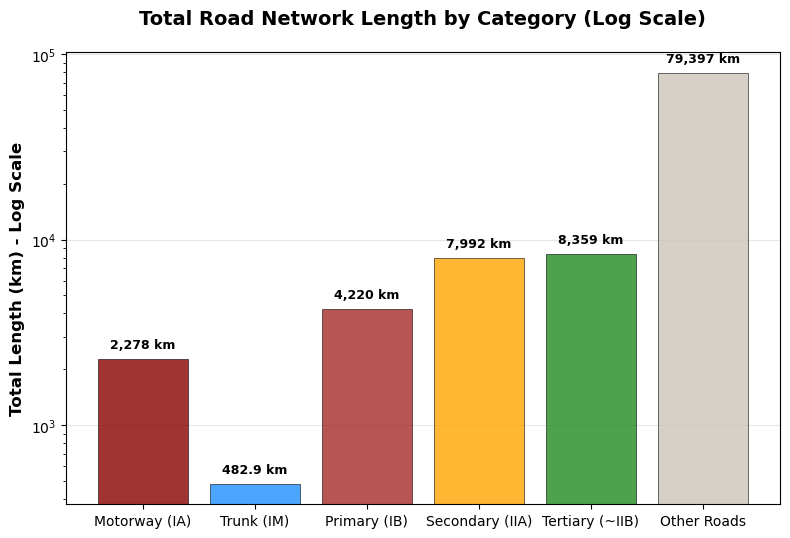

In [31]:
# Convert to CRS 8682 for accurate length calculation in km
network_8682 = base_network_filtered.to_crs(8682)

# Calculate length in kilometers
network_8682['length_km'] = network_8682.geometry.length / 1000

# Group by road category and sum the lengths
length_by_category = network_8682.groupby('road_category')['length_km'].sum().reset_index()

# Define the order for consistent presentation
road_hierarchy = ['motorway', 'trunk', 'primary', 'secondary', 'tertiary', 'other']

# Filter and sort the data according to hierarchy
length_by_category = length_by_category[length_by_category['road_category'].isin(road_hierarchy)]
length_by_category['category_order'] = length_by_category['road_category'].map({cat: i for i, cat in enumerate(road_hierarchy)})
length_by_category = length_by_category.sort_values('category_order')

# Create the bar plot
fig, ax = plt.subplots(1, 1, figsize=(8, 6), facecolor='white')

# Create bars with consistent colors
bars = ax.bar(
    range(len(length_by_category)), 
    length_by_category['length_km'],
    color=[road_colors_osm[cat] for cat in length_by_category['road_category']],
    alpha=0.8,
    edgecolor='black',
    linewidth=0.5
)

# Set x-axis labels
ax.set_xticks(range(len(length_by_category)))
ax.set_xticklabels([road_labels[cat] for cat in length_by_category['road_category']], 
                   fontsize=10, ha='center')

# Check if we need log scale (if max/min ratio > 100)
max_length = length_by_category['length_km'].max()
min_length = length_by_category['length_km'].min()
if max_length / min_length > 100:
    ax.set_yscale('log')
    ax.set_ylabel('Total Length (km) - Log Scale', fontsize=12, fontweight='bold')
    title_suffix = ' (Log Scale)'
else:
    ax.set_ylabel('Total Length (km)', fontsize=12, fontweight='bold')
    title_suffix = ''

# Add value labels on top of bars
for i, (bar, length) in enumerate(zip(bars, length_by_category['length_km'])):
    height = bar.get_height()
    if ax.get_yscale() == 'log':
        # For log scale, place text slightly above the bar
        text_y = height * 1.1
    else:
        text_y = height + max_length * 0.01
    
    # Format the length value
    if length >= 1000:
        label = f'{length:,.0f} km'
    else:
        label = f'{length:.1f} km'
    
    ax.text(bar.get_x() + bar.get_width()/2., text_y, label,
            ha='center', va='bottom', fontsize=9, fontweight='bold')

# Customize the plot
ax.set_title(f'Total Road Network Length by Category{title_suffix}', 
             fontsize=14, fontweight='bold', pad=20)
ax.grid(True, alpha=0.3, axis='y')
ax.set_axisbelow(True)

# Add some styling
plt.tight_layout()
plt.subplots_adjust(bottom=0.15)  # Make room for multi-line x-labels

plt.savefig(figure_path / 'road_length_by_category.png', dpi=300, bbox_inches='tight')
plt.show()